In [5]:
import numpy as np
import scipy as scipy
import scipy.special as special
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import glob
import random
import itertools
from scipy import signal, interpolate, optimize, integrate
from lmfit import Model
from lmfit import Parameters

In [6]:
def load_data_from_aaocsv(folder):
    path = glob.glob('C:/Users/new_f/Documents/RingRes/' + folder + '/W*.CSV')
    _list = []
    nums = []
    head = np.array([])
    numbers_wg = range(0, len(path))

    for n in numbers_wg:
        fulldata = pd.read_csv(path[n], header=None, skiprows=3)
        header = fulldata[0:27]
        num = str.lstrip(path[n], 'C:/Users/new_f/Documents/RingRes/' + folder + '\\W.')
        num = str.rstrip(num, '..CSV')
        num = int(num)
        nums.append(num)
        head = np.append(head, [np.array([num, float(header[1][2]), float(header[1][1]),
                                          float(header[1][7]), int(header[1][10]), float(header[1][11])])])

        if n != 0:
            udata2concat = pd.DataFrame(fulldata[27:][1], dtype=float)
            udata2concat.rename(columns={1: 'Intensity'}, inplace=True)
            _list.append(udata2concat)
        else:
            udata2concat = pd.DataFrame(fulldata[27:], dtype=float)
            udata2concat.rename(columns={0: 'Wavelength', 1: 'Intensity'}, inplace=True)
            _list.append(udata2concat)

    udata = pd.concat(_list, axis=1, keys=nums)
    udata.index = range(len(udata))
    head = pd.DataFrame(head.reshape(len(path), 6))
    head = head.astype({0: int})
    head.rename(columns={0: 'Waveguide Number', 1: 'Initial wavelength', 2: 'Span', 3: 'Resolution',
                         4: 'Final Wavelength', 5: 'Sampling interval'}, inplace=True)

    return udata, head


In [7]:
def load_data_from_mqtxt(folder):

    path = glob.glob('C:/Users/new_f/Documents/RingRes/'+folder+'/wg*.txt')
    _list = []
    nums = []
    
    numbers_wg = np.arange(0, len(path))

    for n in numbers_wg:
        fulldata = pd.read_csv(path[n], skiprows=20, sep='\t')
        num = str.lstrip(path[n], 'C:/Users/new_f/Documents/RingRes/'+folder)
        num = str.lstrip(num, '\\wg.')
        num = str.rstrip(num, 'av10.txt')
        num = str.rstrip(num, '_')
        num = int(num)
        nums.append(num)
        
        if n != 0:
            udata2concat = pd.DataFrame(fulldata['001'], dtype=float)
            udata2concat.rename(columns={'001': 'Intensity'}, inplace=True)
            _list.append(udata2concat)
        else:
            udata2concat = pd.DataFrame(fulldata, dtype=float)
            udata2concat.rename(columns={'0': 'Wavelength', '001': 'Intensity'}, inplace=True)
            _list.append(udata2concat)

    udata = pd.concat(_list, axis=1, keys=nums)
    udata.index = range(len(udata))
        
    return udata


In [8]:
def plot_data(udata, head=0):
    for n in range(0, udata.shape[1]-1):
        plt.subplot(211)
        if n != 0 and type(head) is pd.core.frame.DataFrame:
            plt.plot(udata[0, 'Wavelength'], udata[udata.keys()[n+1][0], 'Intensity']-udata[0, 'Intensity'],
                     label='Waveguide #%i Callibrated' % int(head['Waveguide Number'][n]), color = 'red', lw='0.4')
            plt.ylabel('Throughput (dBm)')
        elif n != 0:
            plt.plot(udata[0, 'Wavelength'], udata[udata.keys()[n+1][0], 'Intensity']-udata[0, 'Intensity'],
                     label='Waveguide #%i Callibrated' % int(udata.keys()[n+1][0]), color = 'red', lw='0.4')
            plt.ylabel('Throughput (dB)')
        else:
            plt.plot(udata[0, 'Wavelength'], udata[n, 'Intensity'], label='Fibre-to-fribre callibration spectra', color = 'red', lw='0.4')
        plt.gcf().set_size_inches(12, 8)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Throughput (dBm)')
        plt.legend()
        plt.show()


In [9]:
def load_waveguide(data, waveguide_number):
    waveguide = np.array([udata[0, 'Wavelength'], udata[waveguide_number, 'Intensity']-udata[0, 'Intensity']])
    #if smooth:
     #   gauss_window = signal.gaussian(100,50)
      #  area = scipy.integrate.trapz(gauss_window)
       # gauss_window = gauss_window/area
        #smoothed = waveguide
        #smoothed[1, 49:-50] = scipy.convolve(smoothed[1], gauss_window, 'valid')
        #return smoothed
    #else:
    return waveguide

In [10]:
def lorentzian(x, I, location, gamma):
    return (I/np.pi)*(gamma/(np.power(x-location,2)+np.power(gamma,2)))

def linear(x,slope,intercept):
    return x*slope + intercept


In [11]:
udata = load_data_from_mqtxt('181116')
#waveguide = load_waveguide(udata, 114)

In [12]:
def model_fit(waveguide, number_peaks, *peakpos):
    
    params = None
    model = Model(linear)
    default_params = {}
    nms = None
    
    if number_peaks == 1:
        model = Model(lorentzian, prefix='f1_') + Model(linear)
        nms = model.param_names
        default_params = {
            nms[0]: 1,
            nms[1]: 1,
            nms[2]: 1,
            nms[-2]: 0,
            nms[-1]: 1,
        }
    elif number_peaks == 2:
        model = Model(lorentzian, prefix='f1_') + Model(lorentzian, prefix='f2_') + Model(linear)
        nms = model.param_names
        default_params = {
            nms[0]: 1,
            nms[1]: 1,
            nms[2]: 1,
            nms[3]: 1,
            nms[4]: 1,
            nms[5]: 1,
            nms[-2]: 0,
            nms[-1]: 1,
        }
    elif number_peaks == 3:
        model = Model(lorentzian, prefix='f1_') + Model(lorentzian, prefix='f2_') +\
                Model(lorentzian, prefix='f3_') + Model(linear)
        nms = model.param_names
        default_params = {
            nms[0]: 1,
            nms[1]: 1,
            nms[2]: 1,
            nms[3]: 1,
            nms[4]: 1,
            nms[5]: 1,
            nms[6]: 1,
            nms[7]: 1,
            nms[8]: 1,
            nms[-2]: 0,
            nms[-1]: 1,
        }

    params = model.make_params(default_params)
 
    model.set_param_hint(nms[0], min=0, max=200, value=1)
    model.set_param_hint(nms[1], min=1450, max=1560, value=peakpos[0])
    model.set_param_hint(nms[2], min=0.000001, max=100, value=1)
    if number_peaks >= 2 :
        model.set_param_hint(nms[3], min=0, max=200, value=1)
        model.set_param_hint(nms[4], min=1535, max=1570, value=peakpos[1])
        model.set_param_hint(nms[5], min=0.000001, max=100, value=1)
    if number_peaks == 3:
        model.set_param_hint(nms[6], min=0, max=700, value=1)
        model.set_param_hint(nms[7], min=1540, max=1650, value=peakpos[2])
        model.set_param_hint(nms[8], min=0.000001, max=100, value=1)

    model.set_param_hint(nms[-2], min=-10, max=10, value=-0.01)
    model.set_param_hint(nms[-1], min=-20, max=100, value=20)
    
    params = model.make_params(default_params)
    print(params)
    
    waveguide[1] = -waveguide[1]
    
    res = model.fit(waveguide[1], params, x=waveguide[0])
    
    return res


In [13]:
def analyse_waveguide(waveguide, number_peaks, *peakpos):
    res = model_fit(waveguide, number_peaks, *peakpos)
    uncert = res.eval_uncertainty(sigma=3)

    plt.scatter(waveguide[0], -waveguide[1], s=0.01)
    plt.plot(waveguide[0], -res.best_fit, color='green')
    plt.errorbar(waveguide[0], -res.best_fit, yerr=uncert, fmt='-o', markersize=0.001, ecolor='red', alpha=0.05)

    plt.gcf().set_size_inches(12, 8)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Throughput (dBm)')

    plt.show()

    components = res.eval_components()
    plt.plot(waveguide[0], -components['f1_'])
    if number_peaks > 1:
        plt.plot(waveguide[0], -components['f2_'])
        if number_peaks == 3:
            plt.plot(waveguide[0], -components['f3_'])
    plt.plot(waveguide[0], -components['linear'])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Throughput (dBm)')
    plt.gcf().set_size_inches(12, 8)

    print(res.fit_report())

    #CUSTOM PRINT TO UPDATE EXCEL SHEET
    #a better solution is to save the result as a xml
    print('\n\n\n\n')

    out = np.zeros(36)

    #FSR

    #POSITION
    out[2] = res.params['f1_location'].value.round(6)
    out[3] = res.params['f1_location'].stderr.round(6)

    #FWHM
    out[8] = 2 * res.params['f1_gamma'].value.round(6)
    out[9] = 2 * res.params['f1_gamma'].stderr.round(6)

    #SLOPE
    out[14] = res.params['slope'].value.round(6)
    out[15] = res.params['slope'].stderr.round(6)

    #INTERCEPT
    out[16] = res.params['intercept'].value.round(6)
    out[17] = res.params['intercept'].stderr.round(6)

    #INTENSITY
    out[18] = res.params['f1_I'].value.round(6)
    out[19] = res.params['f1_I'].stderr.round(6)

    #LOCATION
    out[24]=res.params['f1_location'].value.round(6)
    out[25]=res.params['f1_location'].stderr.round(6)

    #GAMMA
    out[30] = res.params['f1_gamma'].value.round(6)
    out[31] = res.params["f1_gamma"].stderr.round(6)
    
    if number_peaks > 1:
        #FSR
        out[0] = res.params['f2_location'].value.round(6) - res.params['f1_location'].value.round(6)
        out[1] = res.params['f2_location'].stderr.round(6) - res.params['f1_location'].stderr.round(6)
    
        #POSITION
        out[4] = res.params['f2_location'].value.round(6)
        out[5] = res.params['f2_location'].stderr.round(6)
    
        #FWHM
        out[10] = 2 * res.params['f2_gamma'].value.round(6)
        out[11] = 2 * res.params['f2_gamma'].stderr.round(6)
    
        #INTENSITY
        out[20] = res.params['f2_I'].value.round(6)
        out[21] = res.params['f2_I'].stderr.round(6)
    
        #LOCATION
        out[26]=res.params['f2_location'].value.round(6)
        out[27]=res.params['f2_location'].stderr.round(6)
    
        #GAMMA
        out[32] = res.params['f2_gamma'].value.round(6)
        out[33] = res.params["f2_gamma"].stderr.round(6)
        if number_peaks == 3:
            #FSR
            out[0] = (res.params['f3_location'].value.round(6) - res.params['f1_location'].value.round(6))/2
            out[1] = (res.params['f3_location'].stderr.round(6) - res.params['f1_location'].stderr.round(6))/2
        
            #POSITION
            out[6] = res.params['f3_location'].value.round(6)
            out[7] = res.params['f3_location'].stderr.round(6)
        
            #FWHM
            out[12] = 2 * res.params['f3_gamma'].value.round(6)
            out[13] = 2 * res.params['f3_gamma'].stderr.round(6)
        
            #INTENSITY
            out[22] = res.params['f3_I'].value.round(6)
            out[23] = res.params['f3_I'].stderr.round(6)
        
            #LOCATION
            out[28]=res.params['f3_location'].value.round(6)
            out[29]=res.params['f3_location'].stderr.round(6)
        
            #GAMMA
            out[34] = res.params['f3_gamma'].value.round(6)
            out[35] = res.params["f3_gamma"].stderr.round(6)

    out = ','.join([str(i) for i in out])
    print(out)


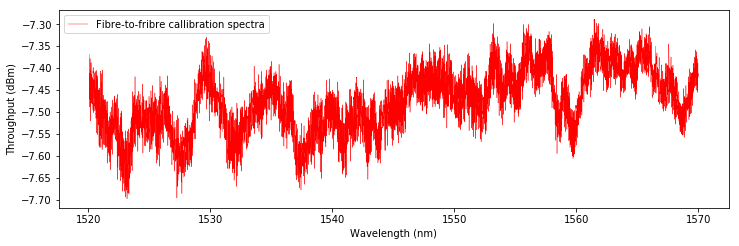

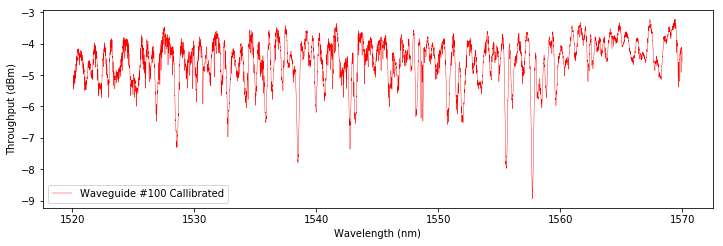

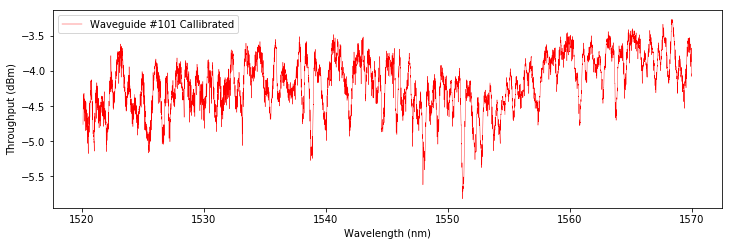

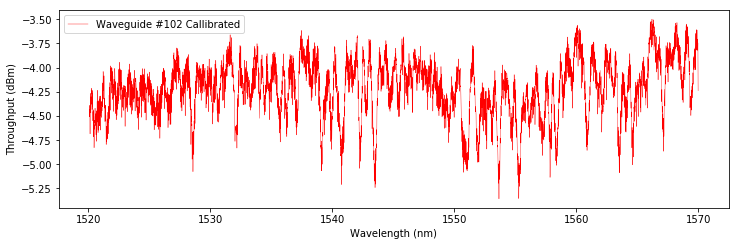

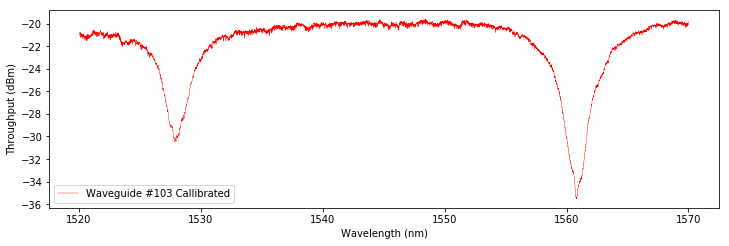

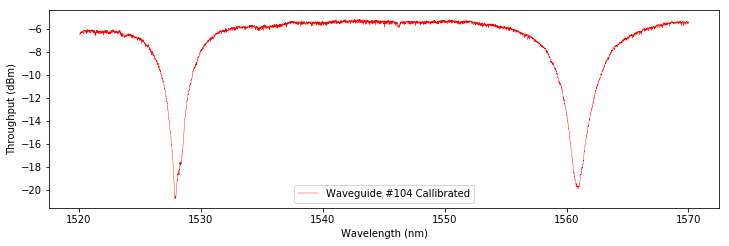

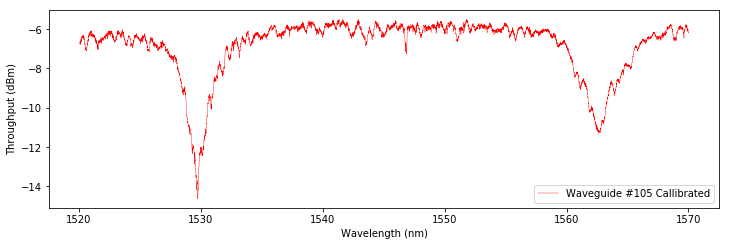

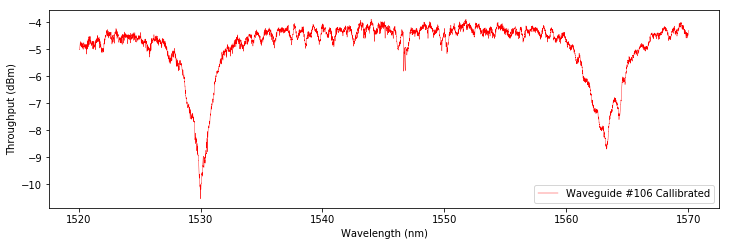

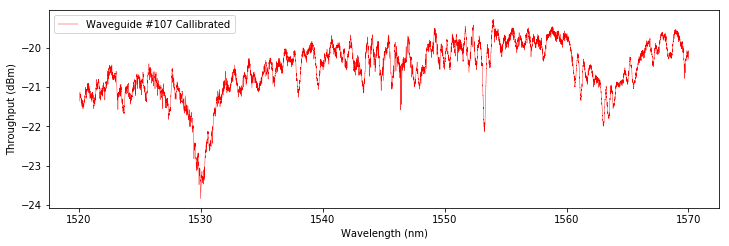

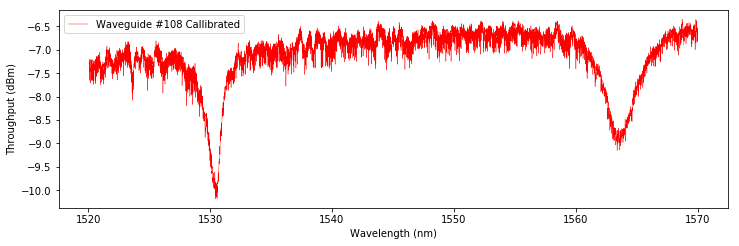

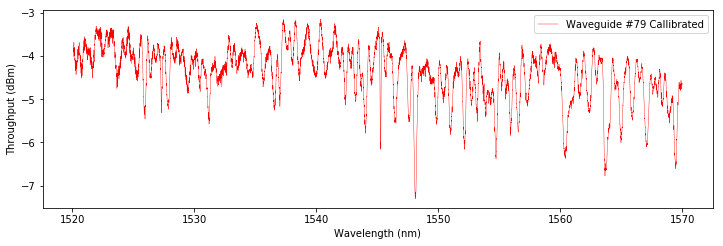

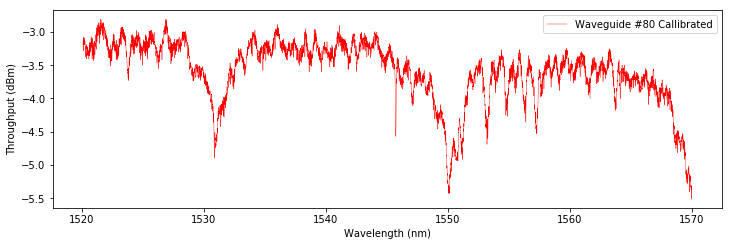

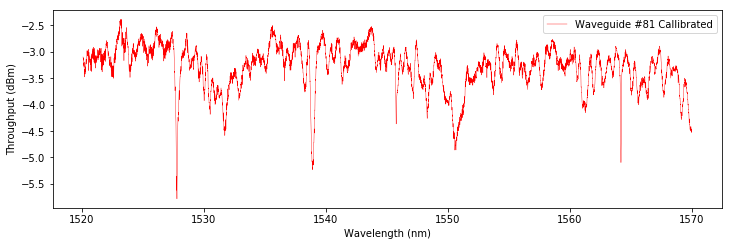

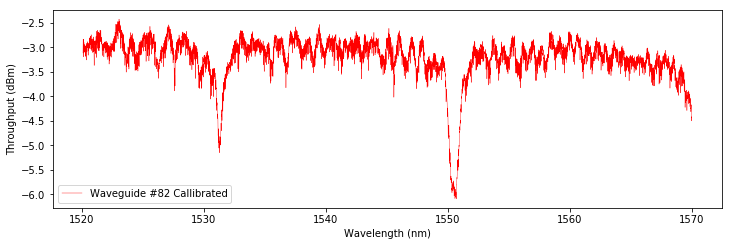

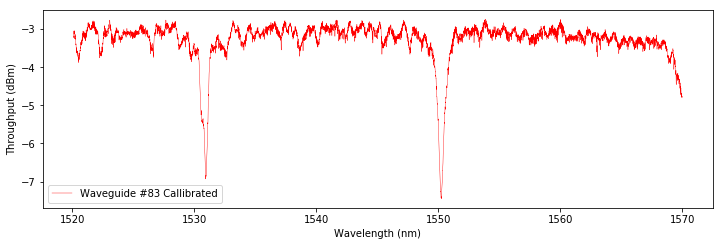

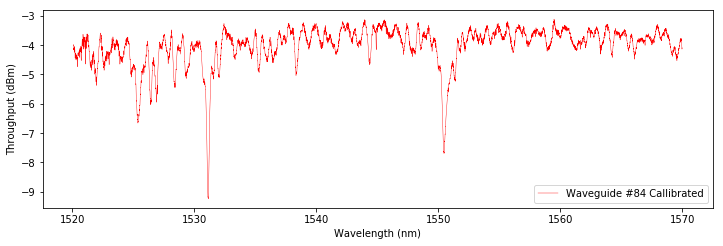

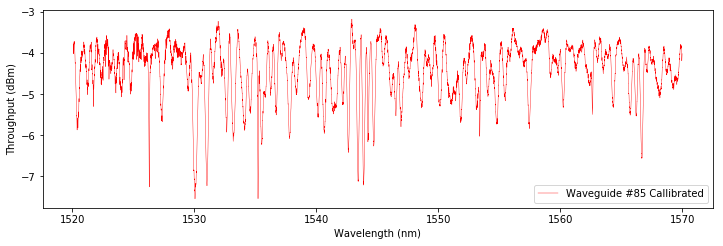

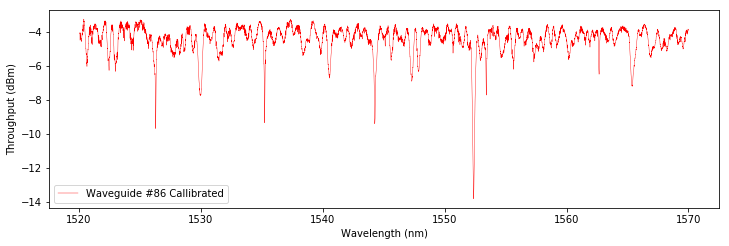

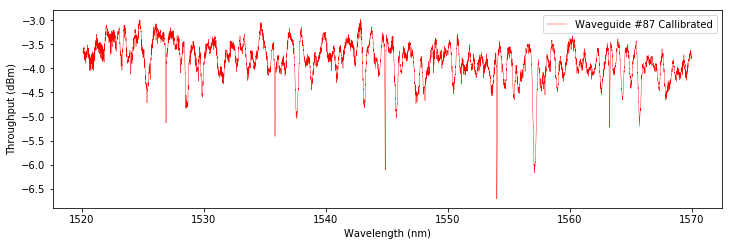

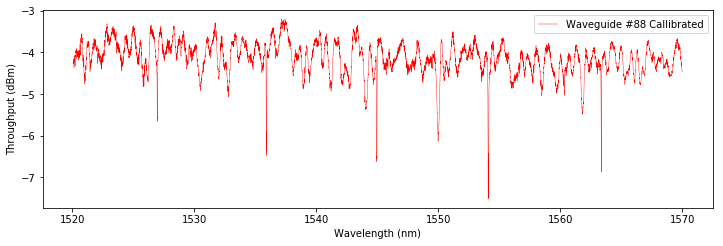

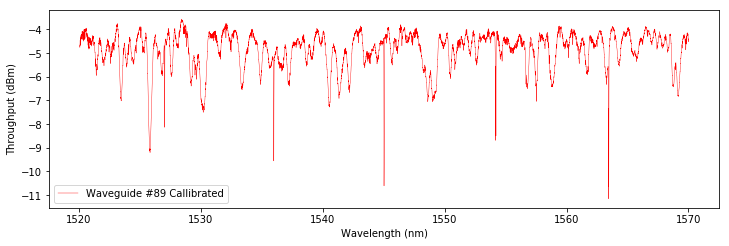

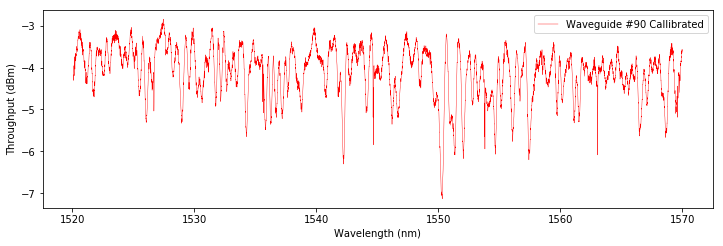

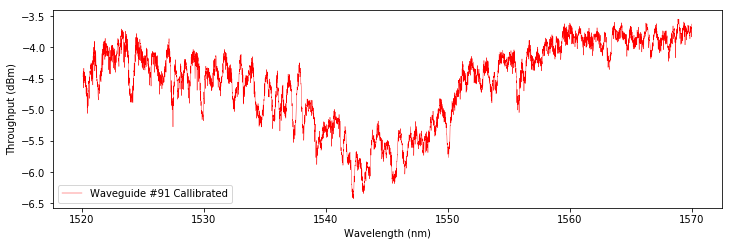

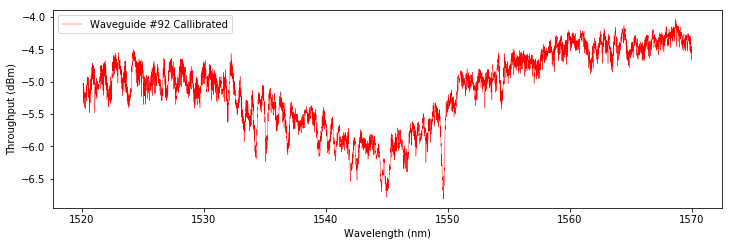

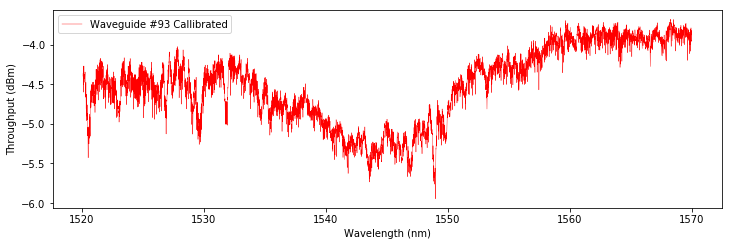

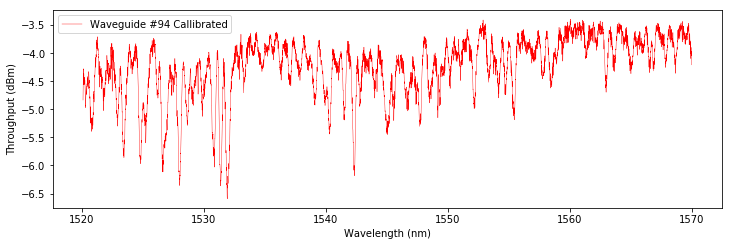

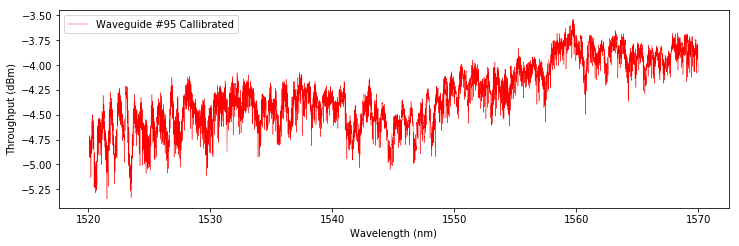

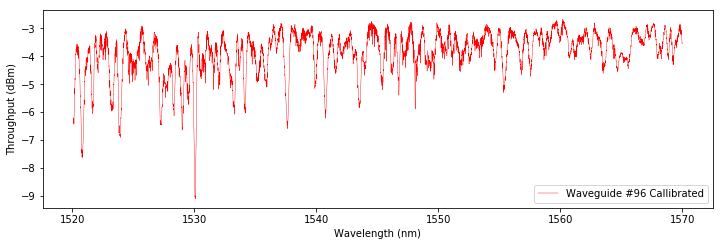

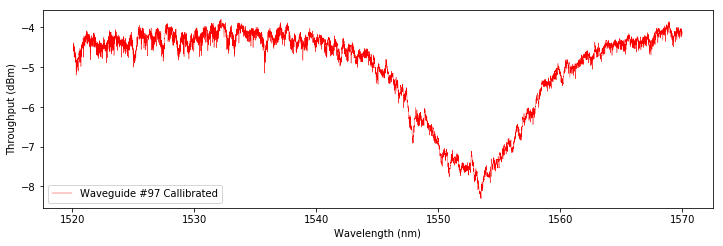

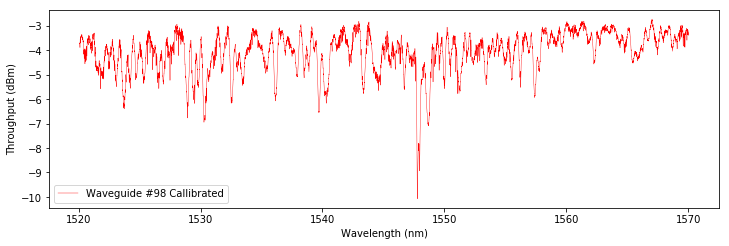

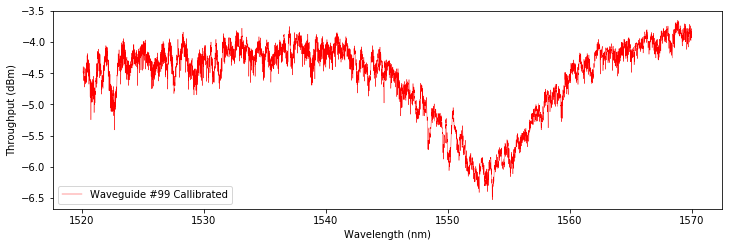

In [14]:
udata = load_data_from_mqtxt('181126')
plot_data(udata)

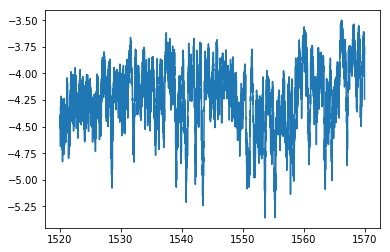

In [15]:
waveguide = load_waveguide(udata, 102)
plt.plot(waveguide[0],waveguide[1])

 - Adding parameter "f1_I"
 - Adding parameter "f1_location"
 - Adding parameter "f1_gamma"
 - Adding parameter "slope"
 - Adding parameter "intercept"
 - Adding parameter "f1_I"
 - Adding parameter "f1_location"
 - Adding parameter "f1_gamma"
 - Adding parameter "slope"
 - Adding parameter "intercept"
Parameters([('f1_I', <Parameter 'f1_I', 1, bounds=[0:200]>), ('f1_location', <Parameter 'f1_location', 1545, bounds=[1450:1560]>), ('f1_gamma', <Parameter 'f1_gamma', 1, bounds=[1e-06:100]>), ('slope', <Parameter 'slope', -0.01, bounds=[-10:10]>), ('intercept', <Parameter 'intercept', 20, bounds=[-20:100]>)])


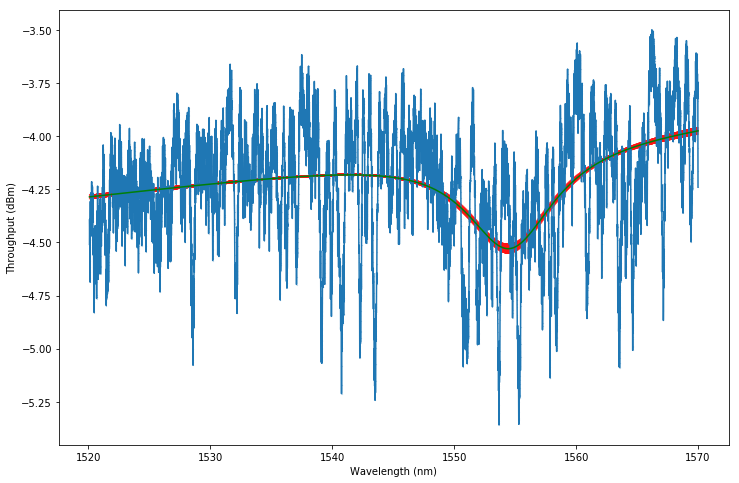

[[Model]]
    (Model(lorentzian, prefix='f1_') + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 120
    # data points      = 16676
    # variables        = 5
    chi-square         = 1169.01987
    reduced chi-square = 0.07012296
    Akaike info crit   = -44311.5542
    Bayesian info crit = -44272.9455
[[Variables]]
    f1_I:         6.75818704 +/- 0.25686287 (3.80%) (init = 1)
    f1_location:  1554.56781 +/- 0.07459294 (0.00%) (init = 1545)
    f1_gamma:     4.42590315 +/- 0.15964965 (3.61%) (init = 1)
    slope:       -0.00680701 +/- 2.0420e-04 (3.00%) (init = -0.01)
    intercept:    14.6248222 +/- 0.31276448 (2.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept)       = -1.000
    C(f1_I, f1_gamma)         =  0.889
    C(f1_I, slope)            = -0.688
    C(f1_I, intercept)        =  0.681
    C(f1_gamma, slope)        = -0.555
    C(f1_gamma, intercept)    =  0.549
    C(f1_location, interc

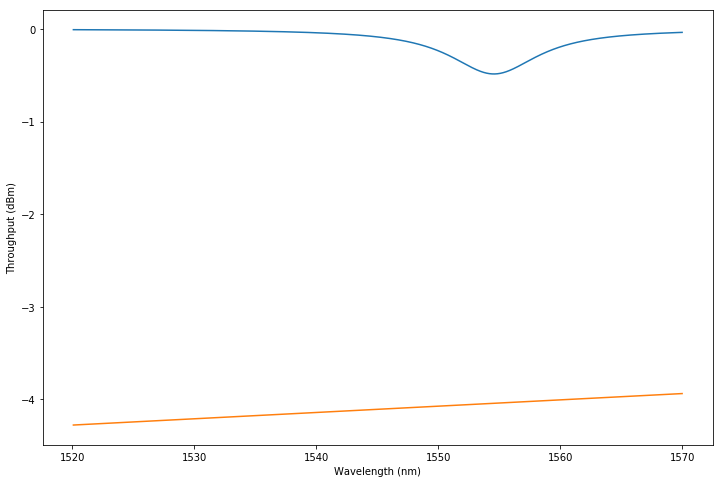

In [16]:
plt.plot(waveguide[0],waveguide[1])
peakposition = np.array([1545])
#analyse_waveguide(waveguide[:,3000:],2,*peakposition)
analyse_waveguide(waveguide,1,*peakposition)


In [17]:
filename = 'C:/Users/new_f/Documents/RingRes/WGS2.xlsx'


In [18]:
data = pd.read_excel(filename, header=None, skiprows=1)

In [19]:
data.fillna(0, inplace=True)

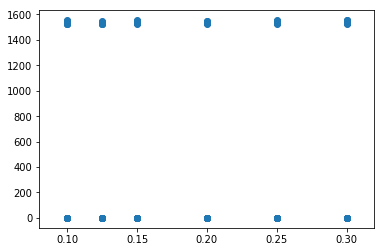

In [20]:
plt.scatter(data[3], data[10])

In [21]:
data

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,1,0.22,0.5,0.100,3.9,0.5,50.931702,2.699311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.032887,0.012458,0.000000,0.000000,0.000000,0.000000
1,2,0.22,0.5,0.125,3.9,0.5,50.931702,2.699311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.22,0.5,0.150,3.9,0.5,50.931702,2.699311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.22,0.5,0.200,3.9,0.5,50.931702,2.699311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.22,0.5,0.250,3.9,0.5,50.931702,2.699311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,0.22,0.5,0.300,3.9,0.5,50.931702,2.699311,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,0.22,0.5,0.100,4.5,0.5,44.140808,2.027483,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.718787,0.041359,0.000000,0.000000,0.000000,0.000000
7,8,0.22,0.5,0.125,4.5,0.5,44.140808,2.027483,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,9,0.22,0.5,0.150,4.5,0.5,44.140808,2.027483,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,0.22,0.5,0.200,4.5,0.5,44.140808,2.027483,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [306]:
def plot_varyingringsep_fringsize(data, rsep): #vary taper and vary ring size but same separation from input variables
    data_array = np.array(data.values, dtype=float)
    ringsize = np.array([3.9,4.5,6.5,10.5,20.5])
    taperw = np.array([0.1,0.15,0.2,0.25])

    for n, ringsep in enumerate(rsep):
        for i,taper in enumerate(taperw):
            plt.subplot(5,5,(i+1)+(5*n))
            plt.gcf().set_size_inches(15, 30)
            plt.tight_layout()

            for rsize in ringsize:
                tw = np.where(data_array[:,1]==taper)[0] #filters by taper width
                data_tw = data_array[tw]
                rd = np.where(data_tw[:,4]==rsize)[0] #then by ring size
                data_rd = data_tw[rd]
                rs = np.where(data_rd[:,3]==ringsep)[0] #then by ring separation
                data_rs = data_rd[rs]

                line1 = plt.scatter(data_rs[:,4],data_rs[:,25]/data_rs[:,37], color='k',marker='+', alpha=1)
                line2 = plt.scatter(data_rs[:,4],10*data_rs[:,15], color='r', marker='*', alpha=0.5)
                line3 = plt.scatter(data_rs[:,4],20*data_rs[:,37], color='b', marker='v', alpha=0.5)
                line4 = plt.scatter(data_rs[:,4],data_rs[:,6], color='y', marker='s', alpha=0.5)

            plt.xlim(0,21.5)
            plt.ylim(-3,80)
            plt.xlabel("Ring Size ($\mu$m)")
            if i==2:
                plt.legend((line1,line2,line3,line4),('Intensity I (dB)', '50*FWHM (nm)', 'Gamma $\gamma$','FSR (nm)'))
            plt.title("Taper "+str(taper)+" $\mu$m and Ring \nSeparation "+ str(ringsep)+"$\mu$m")
    #plt.show()
    plt.savefig("fixed_separation_taperw_f_of_ringsize.png", format='png', dpi=200)

        

def plot_varyingringsep_ftaperw(data, rsep): #vary taper and vary ring size but same separation from input variables
    data_array = np.array(data.values, dtype=float)
    taperw = np.array([0.1,0.15,0.20,0.25])
    ringsize = np.array([3.9,4.5,6.5,10.5,20.5])
    #fig, axs = plt.subplots(1,5, sharey=True) not used anymore

    for n, ringsep in enumerate(rsep):
        for i,rsize in enumerate(ringsize):
            plt.subplot(5,5,(i+1)+(5*n))
            plt.gcf().set_size_inches(15, 30)
            plt.tight_layout()
            for taper in taperw:

                tw = np.where(data_array[:,1]==taper)[0] #filters by taper width
                data_tw = data_array[tw]
                rd = np.where(data_tw[:,4]==rsize)[0] #then by ring size
                data_rd = data_tw[rd]
                rs = np.where(data_rd[:,3]==ringsep)[0] #then by ring separation
                data_rs = data_rd[rs]
                plt.xlim(0,0.33)
                plt.ylim(-3,80)
                plt.xlabel("Taper Width ($\mu$m)")

                line1 = plt.scatter(data_rs[:,1],data_rs[:,25]/data_rs[:,37], color='k',marker='+', alpha=1)
                line2 = plt.scatter(data_rs[:,1],50*data_rs[:,15], color='r', marker='*', alpha=0.5)
                line3 = plt.scatter(data_rs[:,1],20*data_rs[:,37], color='b', marker='v', alpha=0.5)
                line4 = plt.scatter(data_rs[:,1],data_rs[:,6], color='y', marker='s', alpha=0.5)
               

            #axs[0].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR')) used with fig, axs
            #axs[1].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            if i==2:
                plt.legend((line1,line2,line3,line4),('Intensity I (dB)', '50*FWHM (nm)', 'Gamma $\gamma$','FSR (nm)'))
            #axs[3].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            #axs[4].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            plt.title("Ring Size "+str(rsize)+" $\mu$m and Ring \nSeparation "+ str(ringsep)+"$\mu$m")
    #plt.show()
    plt.savefig("fixed_separation_ringsize_f_of_taperw.png", format='png', dpi=200)

In [239]:
def plot_varyingtaperw_fringsize(data, taperw):
    data_array = np.array(data.values, dtype=float)
    ringsep = np.array([0.1,0.15,0.20,0.25,0.30])
    ringsize = np.array([3.9,4.5,6.5,10.5,20.5])
    for n, taperw in enumerate(tw):
        for i,rsep in enumerate(ringsep):
            plt.subplot(5,5,(i+1)+(5*n))
            plt.gcf().set_size_inches(15, 30)
            plt.tight_layout()
            for rsize in ringsize:

                tw = np.where(data_array[:,1]==taperw)[0] #filters by taper width
                data_tw = data_array[tw]
                rd = np.where(data_tw[:,4]==rsize)[0] #then by ring size
                data_rd = data_tw[rd]
                rs = np.where(data_rd[:,3]==rsep)[0] #then by ring separation
                data_rs = data_rd[rs]
                plt.xlim(0,21)
                plt.ylim(-3,80)
                plt.xlabel("Ring Size ($\mu$m)")

                line1 = plt.scatter(data_rs[:,4],data_rs[:,25]/data_rs[:,37], color='k',marker='+', alpha=1)
                line2 = plt.scatter(data_rs[:,4],50*data_rs[:,15], color='r', marker='*', alpha=0.5)
                line3 = plt.scatter(data_rs[:,4],20*data_rs[:,37], color='b', marker='v', alpha=0.5)
                line4 = plt.scatter(data_rs[:,4],data_rs[:,6], color='y', marker='s', alpha=0.5)

            #axs[0].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            #axs[1].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            if i==2:
                plt.legend((line1,line2,line3,line4),('Intensity I (dB)', '50*FWHM (nm)', 'Gamma $\gamma$','FSR (nm)'))
            #axs[3].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            #axs[4].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            plt.title("Ring Separation "+str(rsep)+" $\mu$m and\nTaper Width "+ str(taperw)+"$\mu$m")
    plt.show()
    
def plot_varyingtaperw_fringsep(data, taperw):
    data_array = np.array(data.values, dtype=float)
    ringsep = np.array([0.1,0.15,0.20,0.25,0.30])
    ringsize = np.array([3.9,4.5,6.5,10.5,20.5])

    for n, ringsep in enumerate(rsep):
        for i,rsize in enumerate(ringsize):
            plt.subplot(5,5,(i+1)+(5*n))
            plt.gcf().set_size_inches(15, 30)
            plt.tight_layout()
            for rsep in ringsep:

                tw = np.where(data_array[:,1]==taperw)[0] #filters by taper width
                data_tw = data_array[tw]
                rd = np.where(data_tw[:,4]==rsize)[0] #then by ring size
                data_rd = data_tw[rd]
                rs = np.where(data_rd[:,3]==rsep)[0] #then by ring separation
                data_rs = data_rd[rs]
                #plt.xlim(0,21)
                plt.ylim(-3,80)
                plt.xlabel("Ring Separation ($\mu$m)")

                line1 = plt.scatter(data_rs[:,3],data_rs[:,25]/data_rs[:,37], color='k',marker='+', alpha=1)
                line2 = plt.scatter(data_rs[:,3],50*data_rs[:,15], color='r', marker='*', alpha=0.5)
                line3 = plt.scatter(data_rs[:,3],20*data_rs[:,37], color='b', marker='v', alpha=0.5)
                line4 = plt.scatter(data_rs[:,3],data_rs[:,6], color='y', marker='s', alpha=0.5)

            #axs[0].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            #axs[1].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            if i==2:
                plt.legend((line1,line2,line3,line4),('Intensity I (dB)', '50*FWHM (nm)', 'Gamma $\gamma$','FSR (nm)'))
            #axs[3].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            #axs[4].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
            plt.title("Ring Size "+str(rsize)+" $\mu$m and\nTaper Width "+ str(taperw)+"$\mu$m")
    plt.show()

SyntaxError: invalid syntax (<ipython-input-239-4f094f5866e2>, line 8)

In [240]:
def plot_varyingringsize_fringsep(data, rsize):
    data_array = np.array(data.values, dtype=float)
    ringsep = np.array([0.1,0.15,0.20,0.25,0.30])
    taperw = np.array([0.1,0.15,0.2,0.25])
    fig, axs = plt.subplots(5,5, sharey=True)

    for i,taper in enumerate(taperw):
        plt.subplot(1,5,1+i)
        for rsep in ringsep:

            tw = np.where(data_array[:,1]==taper)[0] #filters by taper width
            data_tw = data_array[tw]
            rd = np.where(data_tw[:,4]==rsize)[0] #then by ring size
            data_rd = data_tw[rd]
            rs = np.where(data_rd[:,3]==rsep)[0] #then by ring separation
            data_rs = data_rd[rs]
            #plt.xlim(0,21)
            plt.ylim(-3,80)
            plt.xlabel("Ring Separation ($\mu$m)")


            line1 = plt.scatter(data_rs[:,3],data_rs[:,25]/data_rs[:,37], color='k',marker='+', alpha=1)
            line2 = plt.scatter(data_rs[:,3],50*data_rs[:,15], color='r', marker='*', alpha=0.5)
            line3 = plt.scatter(data_rs[:,3],20*data_rs[:,37], color='b', marker='v', alpha=0.5)
            line4 = plt.scatter(data_rs[:,3],data_rs[:,6], color='y', marker='s', alpha=0.5)
            plt.gcf().set_size_inches(16, 6)

        #axs[0].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        #axs[1].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        if i==2:
            plt.legend((line1,line2,line3,line4),('Intensity I (dB)', '50*FWHM (nm)', 'Gamma $\gamma$','FSR (nm)'))
        #axs[3].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        #axs[4].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        plt.title("Taper Width "+str(taper)+" $\mu$m and\nRing Size "+ str(rsize)+"$\mu$m")
    plt.show()
        
def plot_varyingringsize_ftaperw(data, rsize):
    data_array = np.array(data.values, dtype=float)
    ringsep = np.array([0.1,0.15,0.20,0.25,0.30])
    taperw = np.array([0.1,0.15,0.2,0.25])
    #fig, axs = plt.subplots(1,5, sharey=True)

    for i,rsep in enumerate(ringsep):
        plt.subplot(1,5,1+i)
        for taper in taperw:

            tw = np.where(data_array[:,1]==taper)[0] #filters by taper width
            data_tw = data_array[tw]
            rd = np.where(data_tw[:,4]==rsize)[0] #then by ring size
            data_rd = data_tw[rd]
            rs = np.where(data_rd[:,3]==rsep)[0] #then by ring separation
            data_rs = data_rd[rs]
            #plt.xlim(0,21)
            plt.ylim(-3,80)
            plt.xlabel("Taper Width ($\mu$m)")

            line1 = plt.scatter(data_rs[:,1],data_rs[:,25]/data_rs[:,37], color='k',marker='+', alpha=1)
            line2 = plt.scatter(data_rs[:,1],50*data_rs[:,15], color='r', marker='*', alpha=0.5)
            line3 = plt.scatter(data_rs[:,1],20*data_rs[:,37], color='b', marker='v', alpha=0.5)
            line4 = plt.scatter(data_rs[:,1],data_rs[:,6], color='y', marker='s', alpha=0.5)
            plt.gcf().set_size_inches(16, 6)

        #axs[0].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        #axs[1].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        if i==2:
            plt.legend((line1,line2,line3,line4),('Intensity I (dB)', '50*FWHM (nm)', 'Gamma $\gamma$','FSR (nm)'))
        #axs[3].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        #axs[4].legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))
        plt.title("Ring Separation "+str(rsep)+" $\mu$m and\nRing Size "+ str(rsize)+"$\mu$m")
    plt.show()
    
    

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


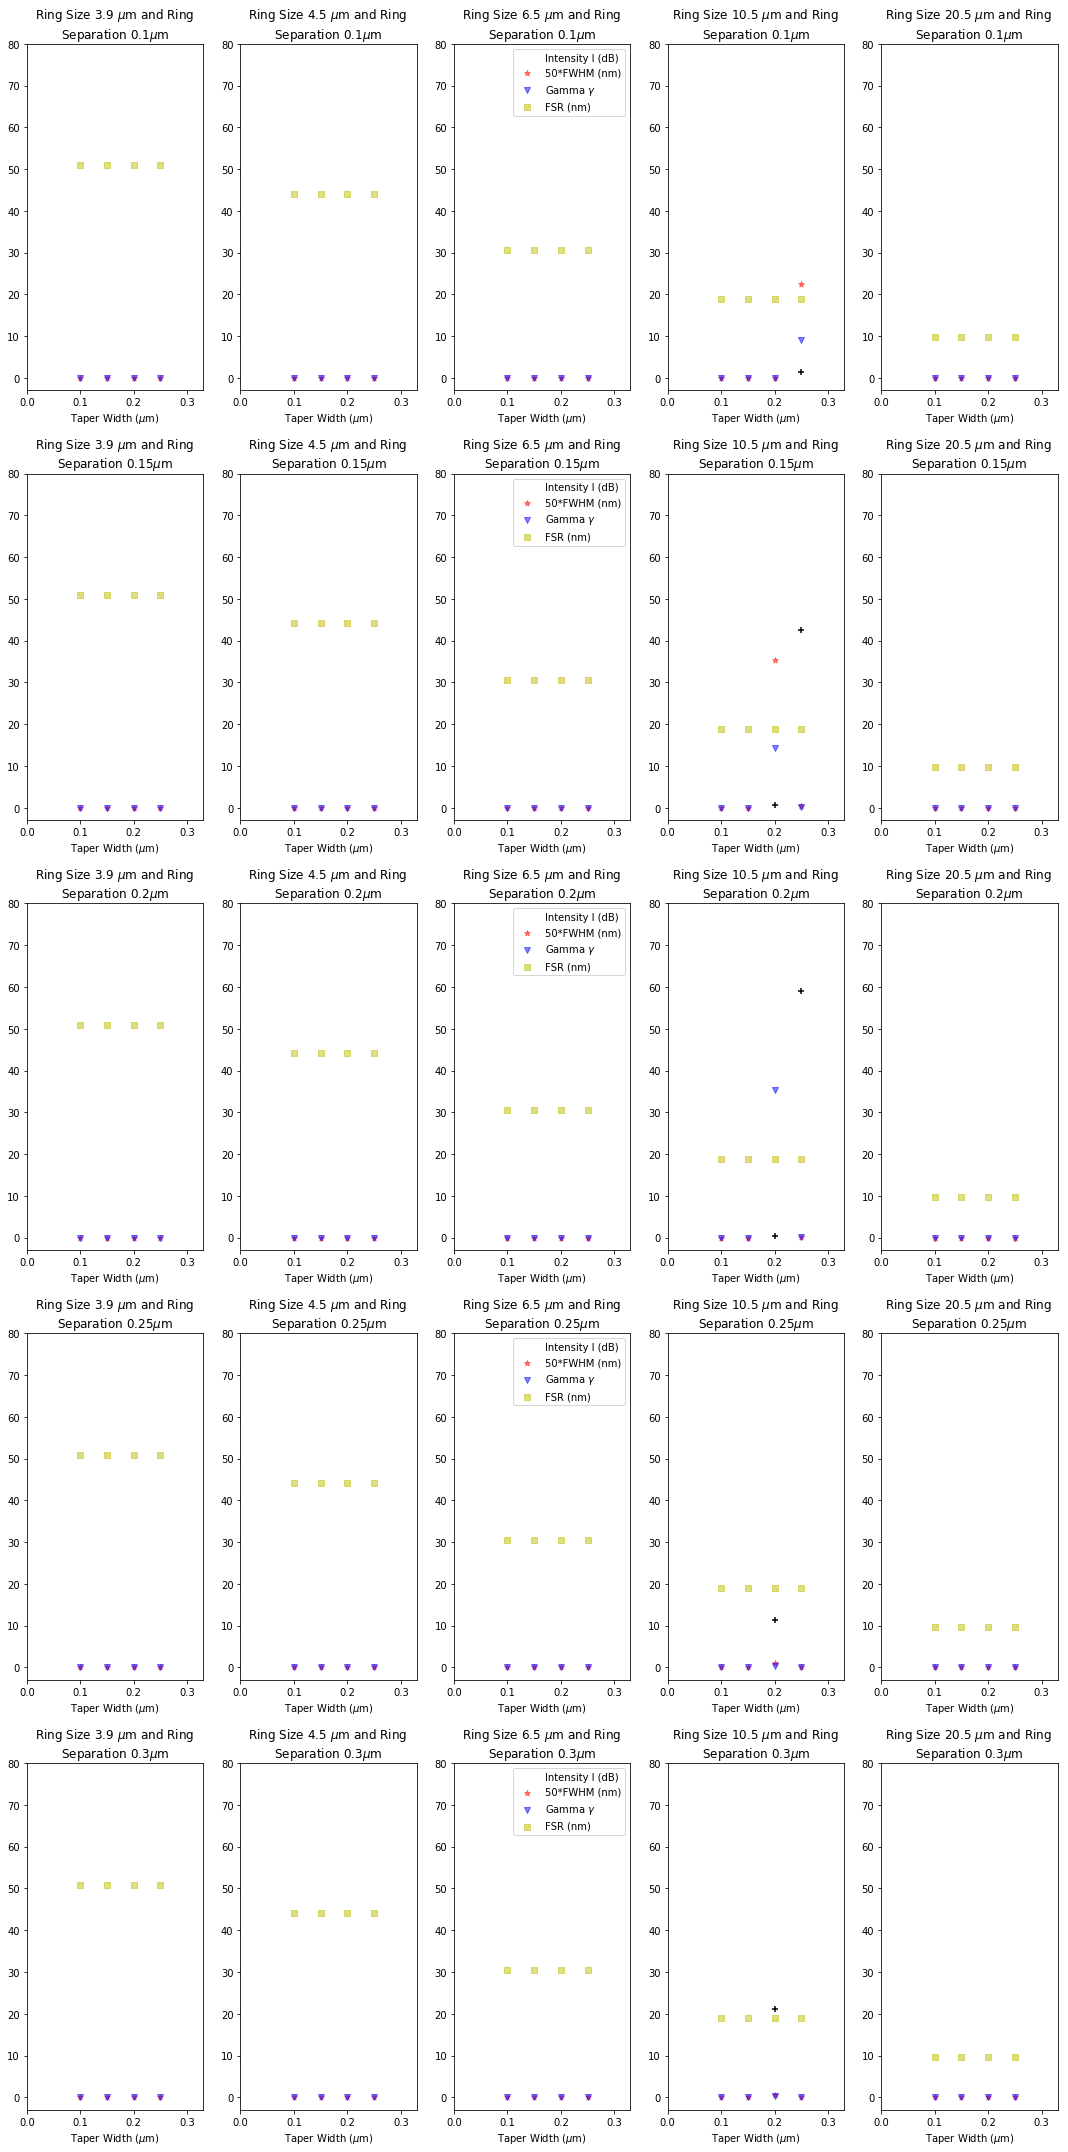

In [307]:
#for n in (0.1,0.15,0.20,0.25, 0.30):
    #plot_varyingringsep_ftaperw(data, n)

varying_parameter = np.array([0.1,0.15,0.20,0.25, 0.30])
    
plot_varyingringsep_ftaperw(data, varying_parameter)

    
    
#for n in (0.1,0.15,0.20,0.25, 0.30):
#    plot_varyingringsep_fringsize(data, n)

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


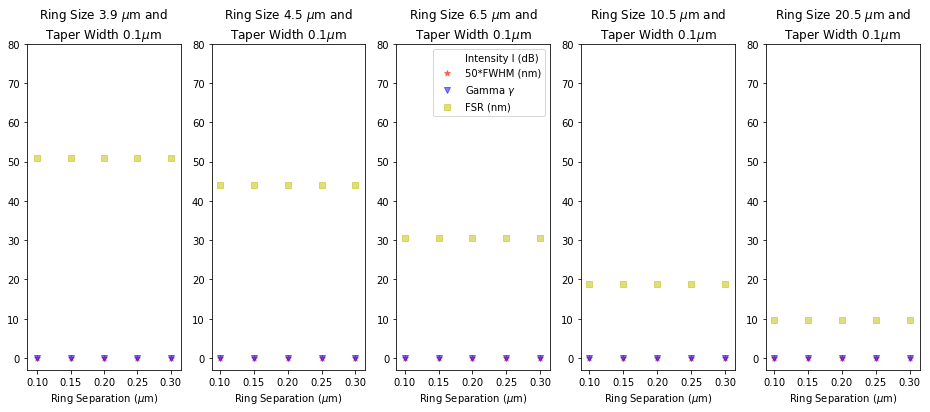

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


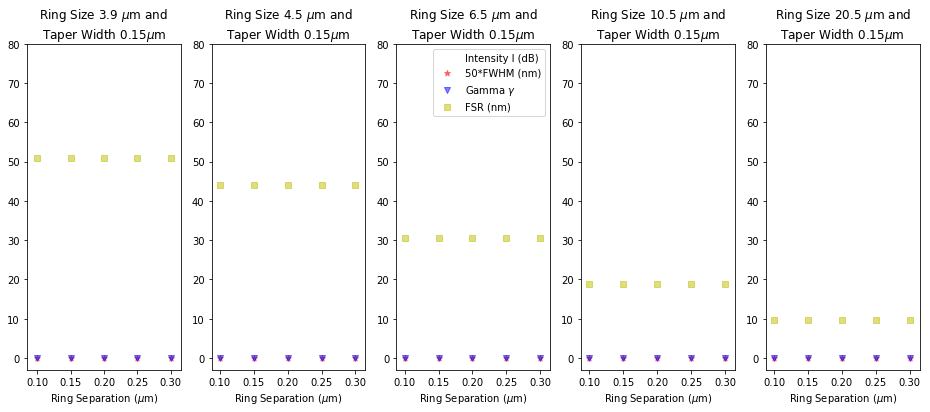

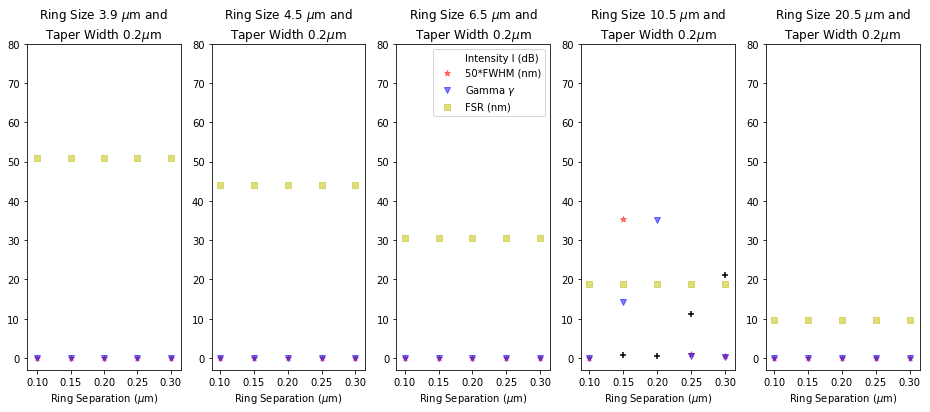

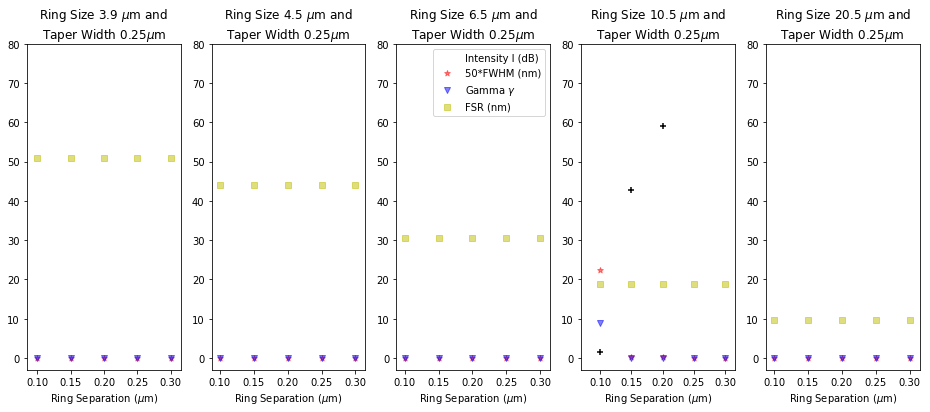

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


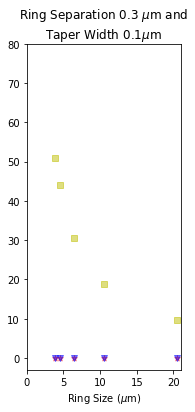

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


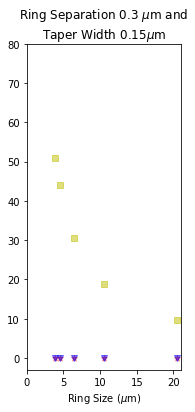

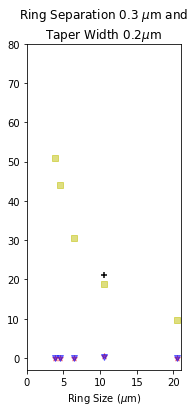

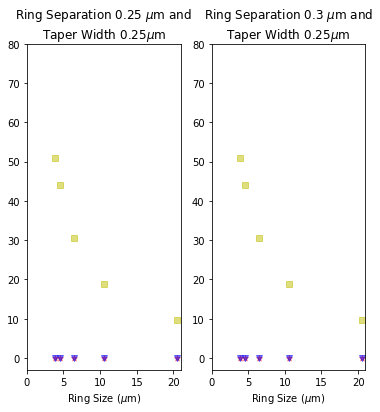

In [242]:
for n in (0.1,0.15,0.20,0.25):
    plot_varyingtaperw_fringsep(data, n)
    
for n in (0.1,0.15,0.20,0.25):
    plot_varyingtaperw_fringsize(data, n)

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


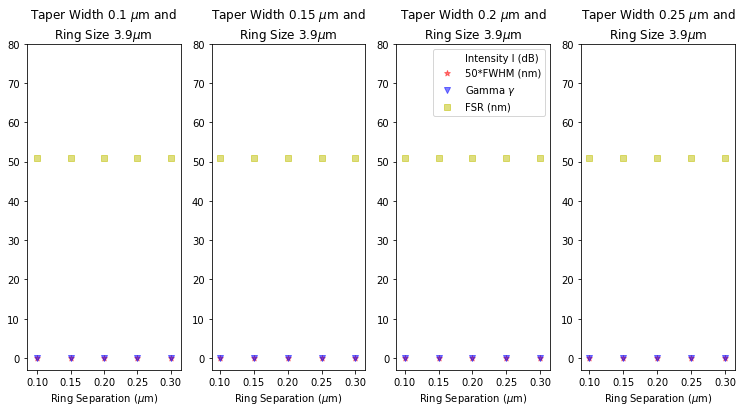

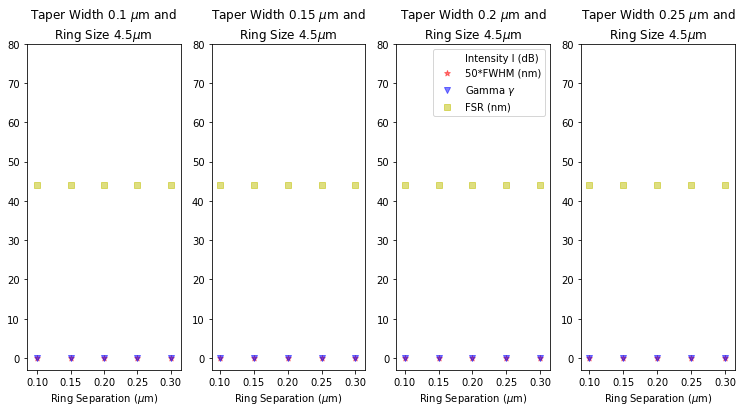

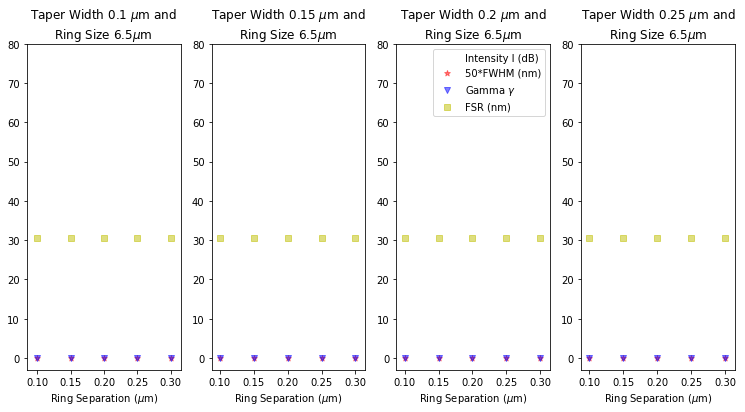

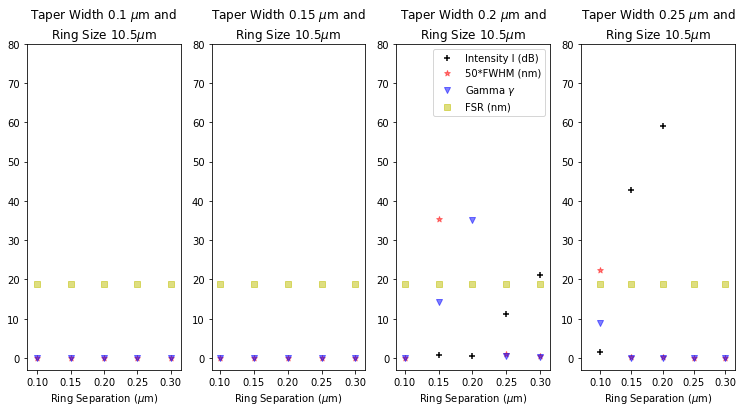

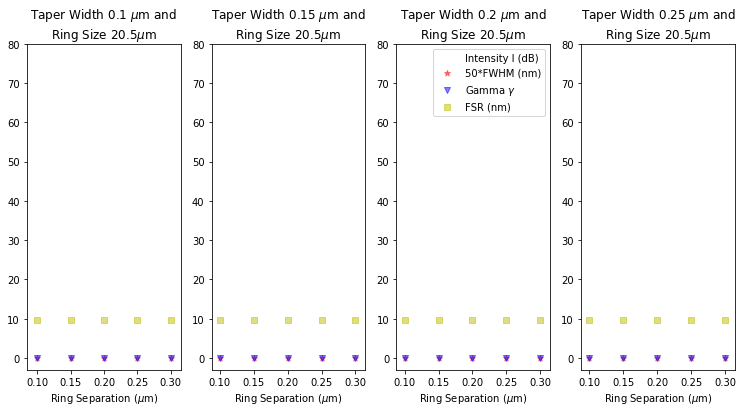

C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


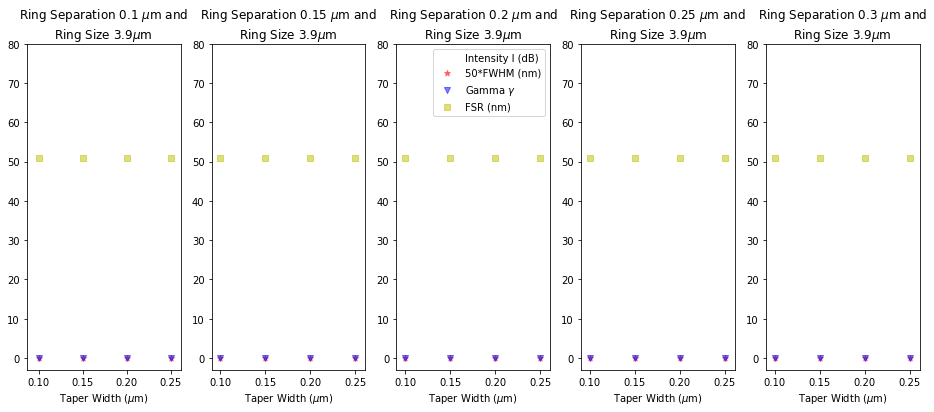

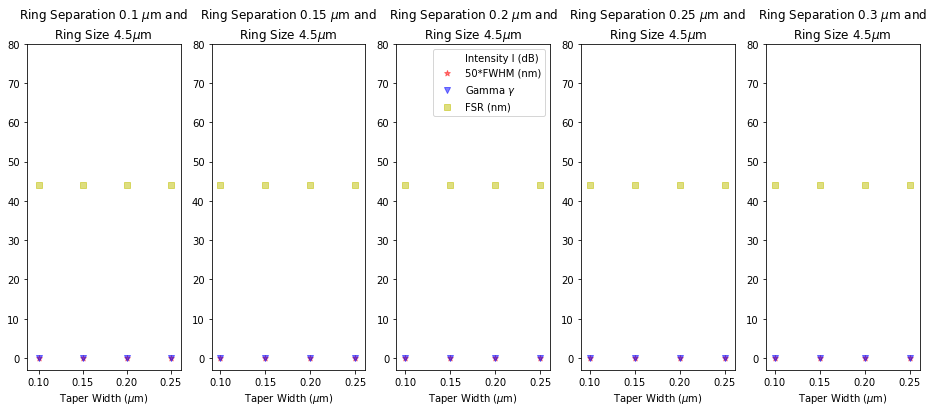

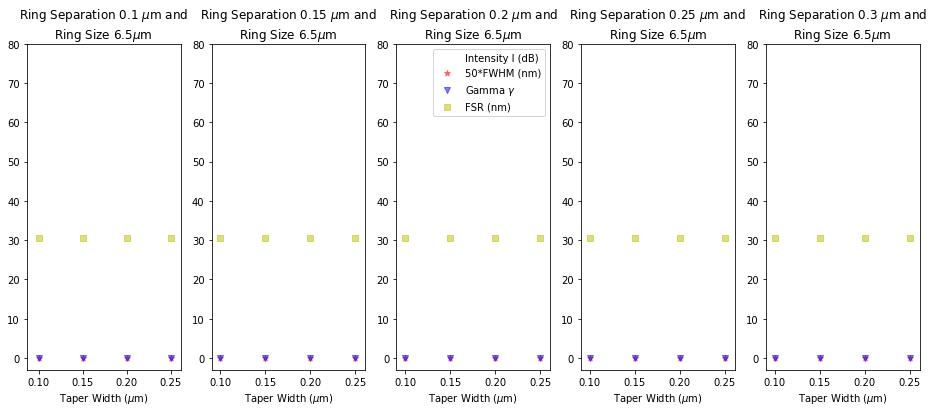

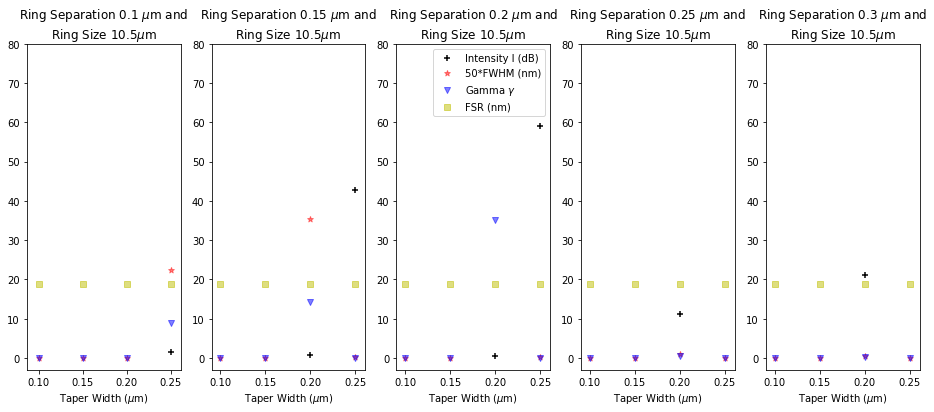

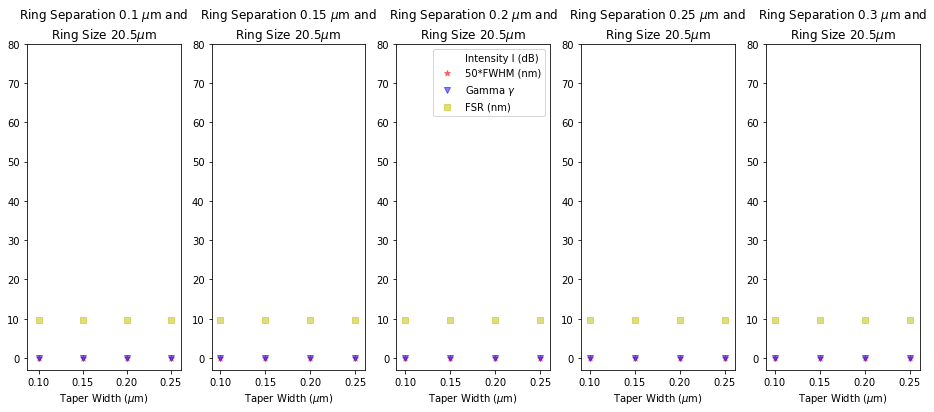

In [168]:
for n in (3.9,4.5,6.5,10.5,20.5):
    plot_varyingringsize_fringsep(data,n)

for n in (3.9,4.5,6.5,10.5,20.5):
    plot_varyingringsize_ftaperw(data,n)

Text(0.5, 1.0, 'AA')

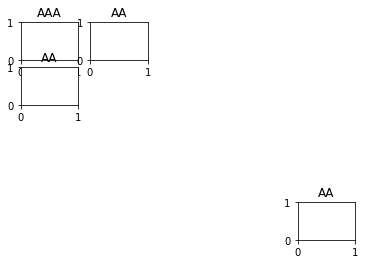

In [208]:
plt.subplot(551)
plt.title("AAA")
plt.subplot(552)
plt.title("AA")
plt.subplot(556)
plt.title("AA")
plt.subplot(5,5,25)
plt.title("AA")


C:\Users\new_f\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


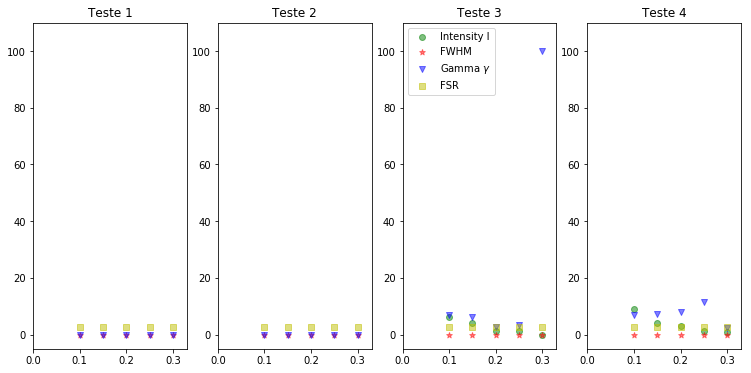

In [122]:
data_array = np.array(data.values, dtype=float)
ringsep = np.array([0.1,0.15,0.20,0.25,0.30])
taperw = np.array([0.1,0.15,0.2,0.25])

for i,taper in enumerate(taperw):
    plt.subplot(151+i)
    plt.title("Teste %i" %(i+1))
    
    for rsep in ringsep:
        tw = np.where(data_array[:,1]==taper)[0] #filters by taper width
        data_tw = data_array[tw]
        rd = np.where(data_tw[:,4]==3.9)[0] #then by ring size
        data_rd = data_tw[rd]
        rs = np.where(data_rd[:,3]==rsep)[0] #then by ring separation
        data_rs = data_rd[rs]

        line1 = plt.scatter(data_rs[:,3],data_rs[:,26]/data_rs[:,38], color='g', alpha=0.5)
        line2 = plt.scatter(data_rs[:,3],data_rs[:,8], color='r', marker='*', alpha=0.5)
        line3 = plt.scatter(data_rs[:,3],data_rs[:,38], color='b', marker='v', alpha=0.5)
        line4 = plt.scatter(data_rs[:,3],data_rs[:,7], color='y', marker='s', alpha=0.5)
        plt.gcf().set_size_inches(16, 6)
    plt.xlim(0,0.33)
    plt.ylim(-5,110)
    if i==2:
        plt.legend((line1,line2,line3,line4),('Intensity I', 'FWHM', 'Gamma $\gamma$','FSR'))

In [ ]:
ax = fig.add_subplot(151+i)


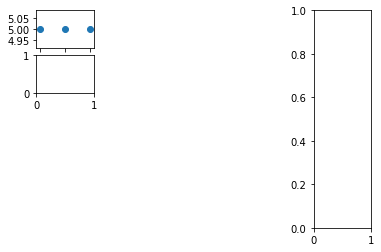

In [284]:
fig = plt.figure()
gs = fig.add_gridspec(5, 5)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
# spans two rows:
ax3 = fig.add_subplot(gs[:, 4])
ax1
ax1.scatter([1,2,3],[5,5,5])

In [292]:
fig = plt.figure()
gs = fig.add_gridspec(5, 5)
axs = fig.add_subplot(gs)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'GridSpec'

<Figure size 432x288 with 0 Axes>